### DOWNLOADING IMAGES


In [ ]:
!pip install duckduckgo-search

In [ ]:
import os
import requests
from PIL import Image
from io import BytesIO
from duckduckgo_search import DDGS

def download_images_duckduckgo(query, folder, num_images=100):
    os.makedirs(folder, exist_ok=True)
    count = 0

    with DDGS() as ddgs:
        results = ddgs.images(query, max_results=num_images)
        for i, result in enumerate(results):
            try:
                url = result['image']
                response = requests.get(url, timeout=5)
                img = Image.open(BytesIO(response.content)).convert("RGB")
                if img.size[0] < 100 or img.size[1] < 100:
                    continue
                img = img.resize((224, 224))
                img.save(f"{folder}/{query}_{count}.jpg")
                count += 1
            except Exception as e:
                print(f"Error with image {i}: {e}")
            if count >= num_images:
                break

    print(f"Downloaded {count} images to {folder}")


In [ ]:
download_images_duckduckgo("chicken", "chicken", 100)
download_images_duckduckgo("duck", "duck", 100)

In [ ]:
import shutil

os.makedirs("dataset/chicken", exist_ok=True)
os.makedirs("dataset/duck", exist_ok=True)

for file in os.listdir("chicken"):
    src = os.path.join("chicken", file)
    dst = os.path.join("dataset/chicken", file)
    if not os.path.exists(dst):
        shutil.move(src, dst)

for file in os.listdir("duck"):
    src = os.path.join("duck", file)
    dst = os.path.join("dataset/duck", file)
    if not os.path.exists(dst):
        shutil.move(src, dst)


shutil.make_archive("chicken_duck_dataset", 'zip', "dataset")

'/content/chicken_duck_dataset.zip'

In [ ]:
from google.colab import files

# Function to download the missing images
def download_missing_images(query, folder, num_images):
    count = 0
    while count < num_images:
        # Download more images until the required number is reached
        download_images_duckduckgo(query, folder, num_images)

        # Ensure the dataset folder exists
        os.makedirs(folder, exist_ok=True)

        # Move images into dataset folders with unique names
        for i, file in enumerate(os.listdir(folder)):
            try:
                shutil.move(f"{folder}/{file}", f"dataset/{query}/{query}_{i + start_index}.jpg")
                count += 1
            except Exception as e:
                print(f"Error with image {i}: {e}")

            if count >= num_images:
                break

# Function to update the zip file
def update_zip():
    # Create or update the zip file
    shutil.make_archive("chicken_duck_dataset_updated", 'zip', "dataset")
    # Remove previous zip file and rename updated zip
    if os.path.exists("chicken_duck_dataset.zip"):
        os.remove("chicken_duck_dataset.zip")
    shutil.move("chicken_duck_dataset_updated.zip", "chicken_duck_dataset.zip")

# Ensure the main dataset directory exists
os.makedirs("dataset/chicken", exist_ok=True)
os.makedirs("dataset/duck", exist_ok=True)

# Calculate the number of images already present in the dataset
chicken_images_count = len(os.listdir("dataset/chicken"))
duck_images_count = len(os.listdir("dataset/duck"))

# Calculate remaining images to download
remaining_chicken = 100 - chicken_images_count
remaining_duck = 100 - duck_images_count

# Get the current image index for renaming
start_index = chicken_images_count + duck_images_count

# Download only missing images
if remaining_chicken > 0:
    download_missing_images("chicken", "chicken", remaining_chicken)

if remaining_duck > 0:
    download_missing_images("duck", "duck", remaining_duck)

# Add newly downloaded images to the existing zip file
update_zip()

# Download the updated zip file
files.download("chicken_duck_dataset.zip")


### Unzip the file

In [ ]:
import zipfile

with zipfile.ZipFile('chicken_duck_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('chicken_duck_dataset')


In [ ]:
# Count the number of images in each folder

chicken_count = len(os.listdir('/content/chicken_duck_dataset/chicken'))
duck_count = len(os.listdir('/content/chicken_duck_dataset/duck'))

print(f"Number of chicken images: {chicken_count}")
print(f"Number of duck images: {duck_count}")
print(f"Total images: {chicken_count + duck_count}")

Number of chicken images: 100
Number of duck images: 100
Total images: 200


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### Split the Dataset

In [ ]:
# Set seed for reproducibility
random.seed(42)

# Original dataset path
original_data_dir = '/content/chicken_duck_dataset'
split_base_dir = 'chicken_duck_dataset_split'

# Class folders
classes = ['chicken', 'duck']

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Create split folder structure
for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(split_base_dir, split, cls), exist_ok=True)

# Split and copy images
for cls in classes:
    cls_path = os.path.join(original_data_dir, cls)

    # Only consider image files
    images = [
        img for img in os.listdir(cls_path)
        if img.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    random.shuffle(images)

    total = len(images)
    train_end = int(train_ratio * total)
    val_end = train_end + int(val_ratio * total)

    train_imgs = images[:train_end]
    val_imgs = images[train_end:val_end]
    test_imgs = images[val_end:]

    # Copy images to their respective directories
    for img_list, split in zip([train_imgs, val_imgs, test_imgs], ['train', 'val', 'test']):
        for img in tqdm(img_list, desc=f'Moving {cls} -> {split}', leave=False):
            src = os.path.join(cls_path, img)
            dst = os.path.join(split_base_dir, split, cls, img)
            shutil.copy2(src, dst)  # copy2 retains metadata

print("\n✅ Dataset split complete!")



✅ Dataset split complete!


In [ ]:
print("Trainning set size :", len(os.listdir('/content/chicken_duck_dataset_split/train/chicken')))
print("Validation set size :", len(os.listdir('/content/chicken_duck_dataset_split/val/chicken')))
print("Test set size :", len(os.listdir('/content/chicken_duck_dataset_split/test/chicken')))

print("Trainning set size :", len(os.listdir('/content/chicken_duck_dataset_split/train/duck')))
print("Validation set size :", len(os.listdir('/content/chicken_duck_dataset_split/val/duck')))
print("Test set size :", len(os.listdir('/content/chicken_duck_dataset_split/test/duck')))


Trainning set size : 70
Validation set size : 15
Test set size : 15
Trainning set size : 70
Validation set size : 15
Test set size : 15


### Set up Generators

In [ ]:
# Set image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Base directory after splitting
base_dir = '/content/chicken_duck_dataset_split'

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['chicken', 'duck']
)

validation_generator = val_test_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'val'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['chicken', 'duck']
)

test_generator = val_test_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'test'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    classes=['chicken', 'duck']
)

# Print class labels
class_labels = list(train_generator.class_indices.keys())
print(f"Class labels: {class_labels}")

Found 140 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Class labels: ['chicken', 'duck']


### Train the Model

In [ ]:
# Load model without the top classifier
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model

# base_model.trainable = False
for layer in base_model.layers:
    layer.trainable = False


# Add custom classifier head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Epoch 100



📘 Training epochs 1 to 10
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 79s 21s/step - accuracy: 0.9317 - loss: 0.2640 - val_accuracy: 0.9000 - val_loss: 0.1541
Epoch 2/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 49s 16s/step - accuracy: 0.9688 - loss: 0.1358

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.9688 - loss: 0.1358 - val_accuracy: 0.9000 - val_loss: 0.1518
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 75s 23s/step - accuracy: 0.8741 - loss: 0.2367 - val_accuracy: 0.9667 - val_loss: 0.1422
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.9375 - loss: 0.1582 - val_accuracy: 0.9667 - val_loss: 0.1431
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 104s 22s/step - accuracy: 0.9497 - loss: 0.1669 - val_accuracy: 0.9667 - val_loss: 0.1462
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.9062 - loss: 0.1839 - val_accuracy: 0.9667 - val_loss: 0.1433
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 109s 19s/step - accuracy: 0.9105 - loss: 0.1890 - val_accuracy: 0.9333 - val_loss: 0.1327
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.9375 - loss: 0.2007 - val_accuracy: 0.9333 - val_loss: 0.1348
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 20s/step - accuracy: 0.9550 - loss: 0.1848 - val_accuracy: 0.9333 - val_loss: 0.1321
Epoch 10/10
4

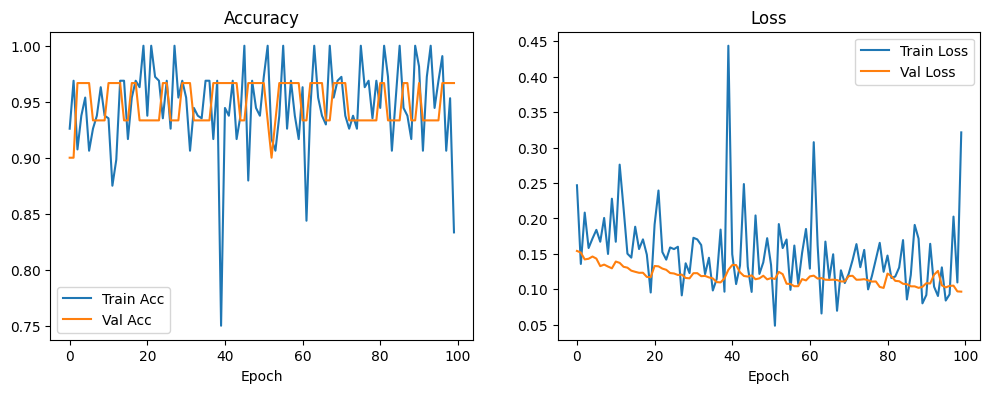

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.9667 - loss: 0.1086
✅ Final Validation Accuracy: 0.9667
✅ Final Validation Loss: 0.1086
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step

📋 Classification Report:
              precision    recall  f1-score   support

     chicken       0.36      0.33      0.34        15
        duck       0.38      0.40      0.39        15

    accuracy                           0.37        30
   macro avg       0.37      0.37      0.37        30
weighted avg       0.37      0.37      0.37        30



In [ ]:
# Train in steps of 10 epochs up to 100
total_epochs = 100
step_size = 10

# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Store history manually
all_history = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': []
}

# Training in steps
for step in range(0, total_epochs, step_size):
    print(f"\n📘 Training epochs {step+1} to {step+step_size}")

    history = model.fit(
        train_generator,
        epochs=step + step_size,
        initial_epoch=step,
        validation_data=validation_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        callbacks= early_stop,
        verbose=1
    )

    # Append history
    for key in all_history:
        all_history[key].extend(history.history.get(key, []))

# Plot full training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(all_history['accuracy'], label='Train Acc')
plt.plot(all_history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.subplot(1, 2, 2)
plt.plot(all_history['loss'], label='Train Loss')
plt.plot(all_history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

# Final evaluation
val_loss, val_acc = model.evaluate(validation_generator, verbose=1)
print(f"✅ Final Validation Accuracy: {val_acc:.4f}")
print(f"✅ Final Validation Loss: {val_loss:.4f}")

# Classification Report
validation_generator.reset()
y_true = validation_generator.classes
y_probs = model.predict(validation_generator, verbose=1)
y_pred = (y_probs > 0.5).astype(int).flatten()

print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

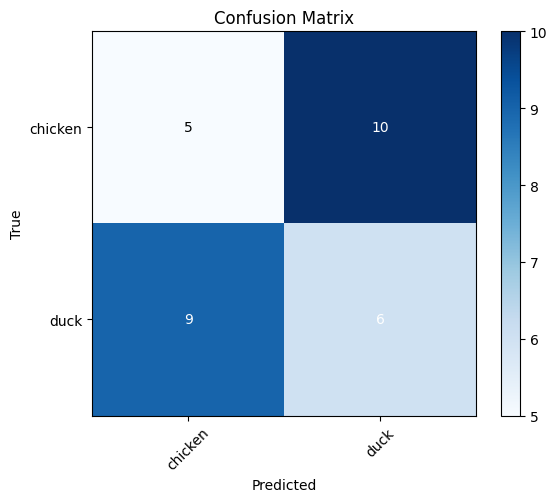

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45)
plt.yticks(np.arange(len(class_labels)), class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")

for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max()/2. else "black")

plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
# Fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    epochs= 15,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

# Final evaluation
val_loss, val_acc = model.evaluate(validation_generator)
print(f"\nAfter fine-tuning - Val Accuracy: {val_acc:.4f}, Val Loss: {val_loss:.4f}")

# Updated classification report
validation_generator.reset()
y_probs = model.predict(validation_generator)
y_pred = (y_probs > 0.5).astype(int).flatten()

print("\nClassification Report after Fine-tuning:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Save model
model.save('/content/duck_chicken_classifier.keras')
print("✅ Model saved as '/content/duck_chicken_classifier'")

Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 91s 27s/step - accuracy: 1.0000 - loss: 0.0315 - val_accuracy: 0.9333 - val_loss: 0.0995
Epoch 2/15
1/4 ━━━━━━━━━━━━━━━━━━━━ 1:00 20s/step - accuracy: 0.9688 - loss: 0.0657

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - accuracy: 0.9688 - loss: 0.0657 - val_accuracy: 0.9333 - val_loss: 0.0970
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 104s 28s/step - accuracy: 1.0000 - loss: 0.0230 - val_accuracy: 0.9333 - val_loss: 0.0960
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 1.0000 - loss: 0.0173 - val_accuracy: 0.9333 - val_loss: 0.0947
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 99s 22s/step - accuracy: 1.0000 - loss: 0.0216 - val_accuracy: 0.9333 - val_loss: 0.0924
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - accuracy: 0.9688 - loss: 0.1075 - val_accuracy: 0.9333 - val_loss: 0.0888
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 100s 22s/step - accuracy: 0.9792 - loss: 0.0290 - val_accuracy: 0.9333 - val_loss: 0.0893
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 7s/step - accuracy: 1.0000 - loss: 0.0214 - val_accuracy: 0.9333 - val_loss: 0.0893
Epoch 9/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 91s 23s/step - accuracy: 0.9942 - loss: 0.0297 - val_accuracy: 0.9333 - val_loss: 0.0946
Epoch 10/15
4